In [449]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Data Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Visualization
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.features.pca import PCADecomposition

# Metrics
#from sklearn.metrics import mean_squared_error as MSE
#from sklearn.metrics import mean_absolute_error as MAE
#from sklearn.metrics import r2_score as R2

In [270]:
plt.rcParams["figure.figsize"] = [16,4]

pd.options.display.width = 0
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
np.set_printoptions(threshold=30)

In [271]:
def flatten(nested_lst):
    flattened_lst = [elem for lst in nested_lst for elem in lst]
    return flattened_lst

In [272]:
def drop_features_from_dict(features, discarded):
    for key in features:
        for feat in discarded:
            if feat in features[key]:
                features[key].remove(feat)

In [273]:
def get_features(data):
    target = [feat for feat in features["target"] if feat in data.columns]
    cont = [feat for feat in features["cont"] if feat in data.columns]
    discrete = [feat for feat in features["discrete"] if feat in data.columns]
    ordinal = [feat for feat in features["ordinal"] if feat in data.columns]
    nominal = [feat for feat in features["nominal"] if feat in data.columns]
    return target, cont, discrete, ordinal, nominal

In [274]:
def get_categories(data):
    target, cont, discrete, ordinal, nominal = get_features(data)
    ordinal_categories = [ordinal_cat_dict[key] for key in data[ordinal].columns]
    nominal_categories = [nominal_cat_dict[key] for key in data[nominal].columns]
    return ordinal_categories, nominal_categories

In [275]:
def split_data(data, stratify_crit, test_size=0.2, random_state=None):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, stratify_crit): # There is no loop really
        data_train = data.iloc[train_index].copy()
        data_test = data.iloc[test_index].copy()
    return data_train, data_test

In [276]:
def prepare_data_for_model(train, val_size=None, random_state=None):
    y = train[features["target"]].to_numpy().reshape(-1)
    X = train.drop(columns=features["target"])
    if val_size is not None:
        return train_test_split(X, y, test_size=val_size, random_state=random_state)
    return X, y

In [277]:
def score_model(model, X, y, metrics, cv=10):
    cv_scores = cross_validate(model, X, y, cv=cv, scoring=list(metrics.values()), n_jobs=-1)
    for key, value in metrics.items():   
        print("{}: {}".format(key, cv_scores['test_'+value].mean()))
    #return cv_scores

In [278]:
metrics = {'R2':'r2', 'MAE':'neg_mean_absolute_error', 'RMSE':'neg_root_mean_squared_error'}

# Data Preparation

In [279]:
housing = pd.read_csv("../data/AmesHousing.csv")

In [280]:
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,

In [281]:
housing.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766815,472.819734,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760566,215.046549,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [282]:
features = {
    "nominal": ["MS SubClass", "MS Zoning", "Street", "Alley", 
              "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
              "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
              "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
              "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"],
    "ordinal": ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", 
              "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", 
              "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", 
              "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", 
              "Paved Drive", "Pool QC", "Fence"],
    "cont": ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", 
                 "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", 
                 "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", 
                 "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"],
    "discrete": ["Year Built", "Year Remod/Add", "Full Bath", "Half Bath", "Bsmt Full Bath", "Bsmt Half Bath",
                "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt", 
                "Garage Cars", "Mo Sold", "Yr Sold"],
    "target": ["SalePrice"]
}

In [283]:
print("Nominal: {}\nOrdinal: {}\nContinuous: {}\nDiscrete: {}".format(
    len(features["nominal"]), len(features["ordinal"]), len(features["cont"]), len(features["discrete"])))

Nominal: 23
Ordinal: 23
Continuous: 19
Discrete: 14


In [284]:
housing["MS SubClass"] = housing["MS SubClass"].apply(str)

In [285]:
nominal_cat_dict = {
    'Lot Config': ["Inside", "Corner", "CulDSac", "FR2", "FR3"],
    'House Style': ["1Story", "1.5Fin", "1.5Unf", "2Story", "2.5Fin", "2.5Unf", "SFoyer", "SLvl"],
    'Land Contour': ["Lvl", "Bnk", "HLS", "Low"],
    'MS SubClass': ["20", "30", "40", "45", "50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
    'Exterior 2nd': ["AsbShng", "AsphShn", "Brk Cmn", "BrkFace", "CBlock", "CmentBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "Wd Shng"],
    'Garage Type': ["2Types", "Attchd", "Basment", "BuiltIn", "CarPort", "Detchd", "NA"],
    'Misc Feature': ["Elev", "Gar2", "Othr", "Shed", "TenC", "NA"],
    'Street': ["Grvl", "Pave"],
    'Roof Matl': ["ClyTile", "CompShg", "Membran", "Metal", "Roll", "Tar&Grv", "WdShake", "WdShngl"],
    'Sale Type': ["WD ", "CWD", "VWD", "New", "COD", "Con", "ConLw", "ConLI", "ConLD", "Oth"],
    'Sale Condition': ["Normal", "Abnorml", "AdjLand", "Alloca", "Family", "Partial"],
    'Alley': ["Grvl", "Pave", "NA"],
    'Condition 2': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Exterior 1st': ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
    'Neighborhood': ["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", 
                     "Gilbert", "Greens", "GrnHill", "IDOTRR", "Landmrk", "MeadowV", "Mitchel", "NAmes", 
                     "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", 
                     "Somerst", "StoneBr", "Timber", "Veenker"],
    'Roof Style': ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
    'Foundation': ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
    'MS Zoning': ["A (agr)", "C (all)", "FV", "I (all)", "RH", "RL", "RP", "RM"],
    'Central Air': ["N", "Y"],
    'Heating': ["Floor", "GasA", "GasW", "Grav", "OthW", "Wall"],
    'Bldg Type': ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
    'Condition 1': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Mas Vnr Type': ["BrkCmn", "BrkFace", "CBlock", "None", "Stone"],
}

In [286]:
ordinal_cat_dict = {
    'Kitchen Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Overall Cond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Exter Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Fence': ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
    'Bsmt Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Utilities': ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    'Electrical': ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    'Heating QC': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Garage Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Pool QC': ["NA", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Paved Drive': ["N", "P", "Y"], 
    'Land Slope': ["Sev", "Mod", "Gtl"], 
    'Lot Shape': ["IR3", "IR2", "IR1", "Reg"], 
    'Functional': ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    'BsmtFin Type 1': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Overall Qual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'Garage Finish': ["NA", "Unf", "RFn", "Fin"], 
    'BsmtFin Type 2': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Garage Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Fireplace Qu': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Exter Cond': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Exposure': ["NA", "No", "Mn", "Av", "Gd"]
}

In [287]:
tofill_features = [
    'Pool QC', 'Misc Feature', 'Alley', 'Fence', 
    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Garage Finish', 
    'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2',
    'BsmtFin Type 1', 'Bsmt Cond', 'Bsmt Qual']

housing[tofill_features] = housing[tofill_features].fillna("NA")

In [288]:
criteria = pd.cut(housing["SalePrice"], bins=20, labels=range(20))
train, test = split_data(housing, stratify_crit=criteria, test_size=0.2, random_state=99)

In [289]:
print(train.shape)
print(test.shape)

(2344, 82)
(586, 82)


In [290]:
nas = train.isna().sum()
nas = nas[nas > 0].sort_values(ascending=False)
nas

Lot Frontage      384
Garage Yr Blt     127
Mas Vnr Area       19
Mas Vnr Type       19
Bsmt Half Bath      2
Bsmt Full Bath      2
Electrical          1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [291]:
train["Lot Frontage"] = train["Lot Frontage"].fillna(0)

In [292]:
(train["Garage Yr Blt"] == train["Year Built"]).sum()

1775

In [293]:
train.loc[train["Garage Yr Blt"].isna(), "Garage Yr Blt"] = train.loc[train["Garage Yr Blt"].isna(), "Year Built"]

In [294]:
train["Mas Vnr Area"] = train["Mas Vnr Area"].fillna(0)
train["Mas Vnr Type"] = train["Mas Vnr Type"].fillna("None")

In [295]:
train = train.dropna(axis=0)

In [296]:
train = train.drop(columns=["PID", "Order"])

In [297]:
train.isna().sum().sum()

0

In [298]:
target, cont, discrete, ordinal, nominal = get_features(train)
all_features = target + cont + discrete + ordinal + nominal
train = train[all_features]

In [299]:
train[target] = train[target].astype("float64")
train[cont] = train[cont].astype("float64")
train[discrete] = train[discrete].astype("int64")

In [301]:
ordinal_categories, nominal_categories = get_categories(train)
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
train_ord = ordinal_encoder.fit_transform(train[ordinal])
train[ordinal] = train_ord
train[ordinal] = train[ordinal].astype("int64")
#train_du = pd.get_dummies(train, columns=nominal, drop_first=False)
#train_df = pd.get_dummies(train, columns=nominal, drop_first=True)

In [302]:
#train_full = train.copy()
#criteria = pd.cut(train_full["SalePrice"], bins=20, labels=range(20))
#train, valid = prepare_test_data(train_full, criteria, test_size=0.2, random_state=50)

In [303]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 1196 to 1320
Data columns (total 80 columns):
SalePrice          2341 non-null float64
Lot Frontage       2341 non-null float64
Lot Area           2341 non-null float64
Mas Vnr Area       2341 non-null float64
BsmtFin SF 1       2341 non-null float64
BsmtFin SF 2       2341 non-null float64
Bsmt Unf SF        2341 non-null float64
Total Bsmt SF      2341 non-null float64
1st Flr SF         2341 non-null float64
2nd Flr SF         2341 non-null float64
Low Qual Fin SF    2341 non-null float64
Gr Liv Area        2341 non-null float64
Garage Area        2341 non-null float64
Wood Deck SF       2341 non-null float64
Open Porch SF      2341 non-null float64
Enclosed Porch     2341 non-null float64
3Ssn Porch         2341 non-null float64
Screen Porch       2341 non-null float64
Pool Area          2341 non-null float64
Misc Val           2341 non-null float64
Year Built         2341 non-null int64
Year Remod/Add     2341 non-nul

# Exploratory Analysis

In [304]:
data = train.copy()

## Histogram of target variable (SalePrice)

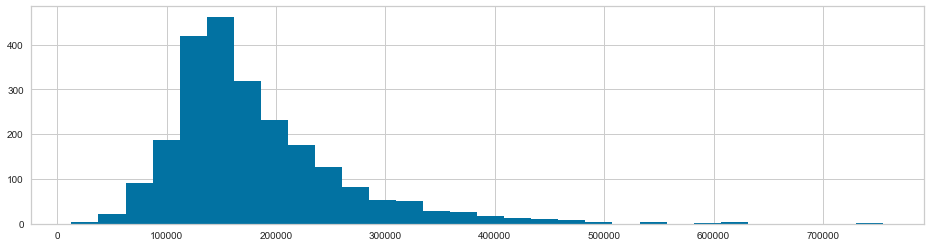

In [305]:
data["SalePrice"].hist(bins=30);

## Sorted plot of target

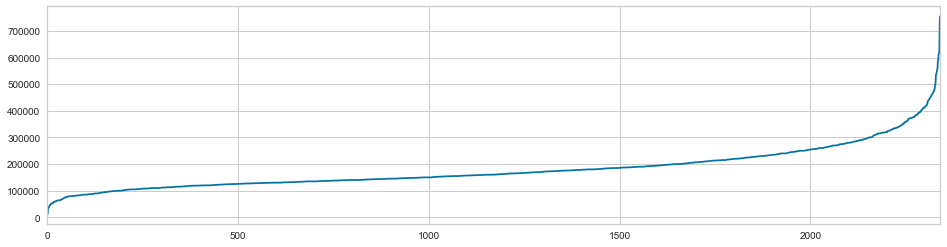

In [306]:
data_sorted_price = data["SalePrice"].sort_values()
data_sorted_price.index = range(len(data_sorted_price))
data_sorted_price.plot();

## Histograms numerical features vs target

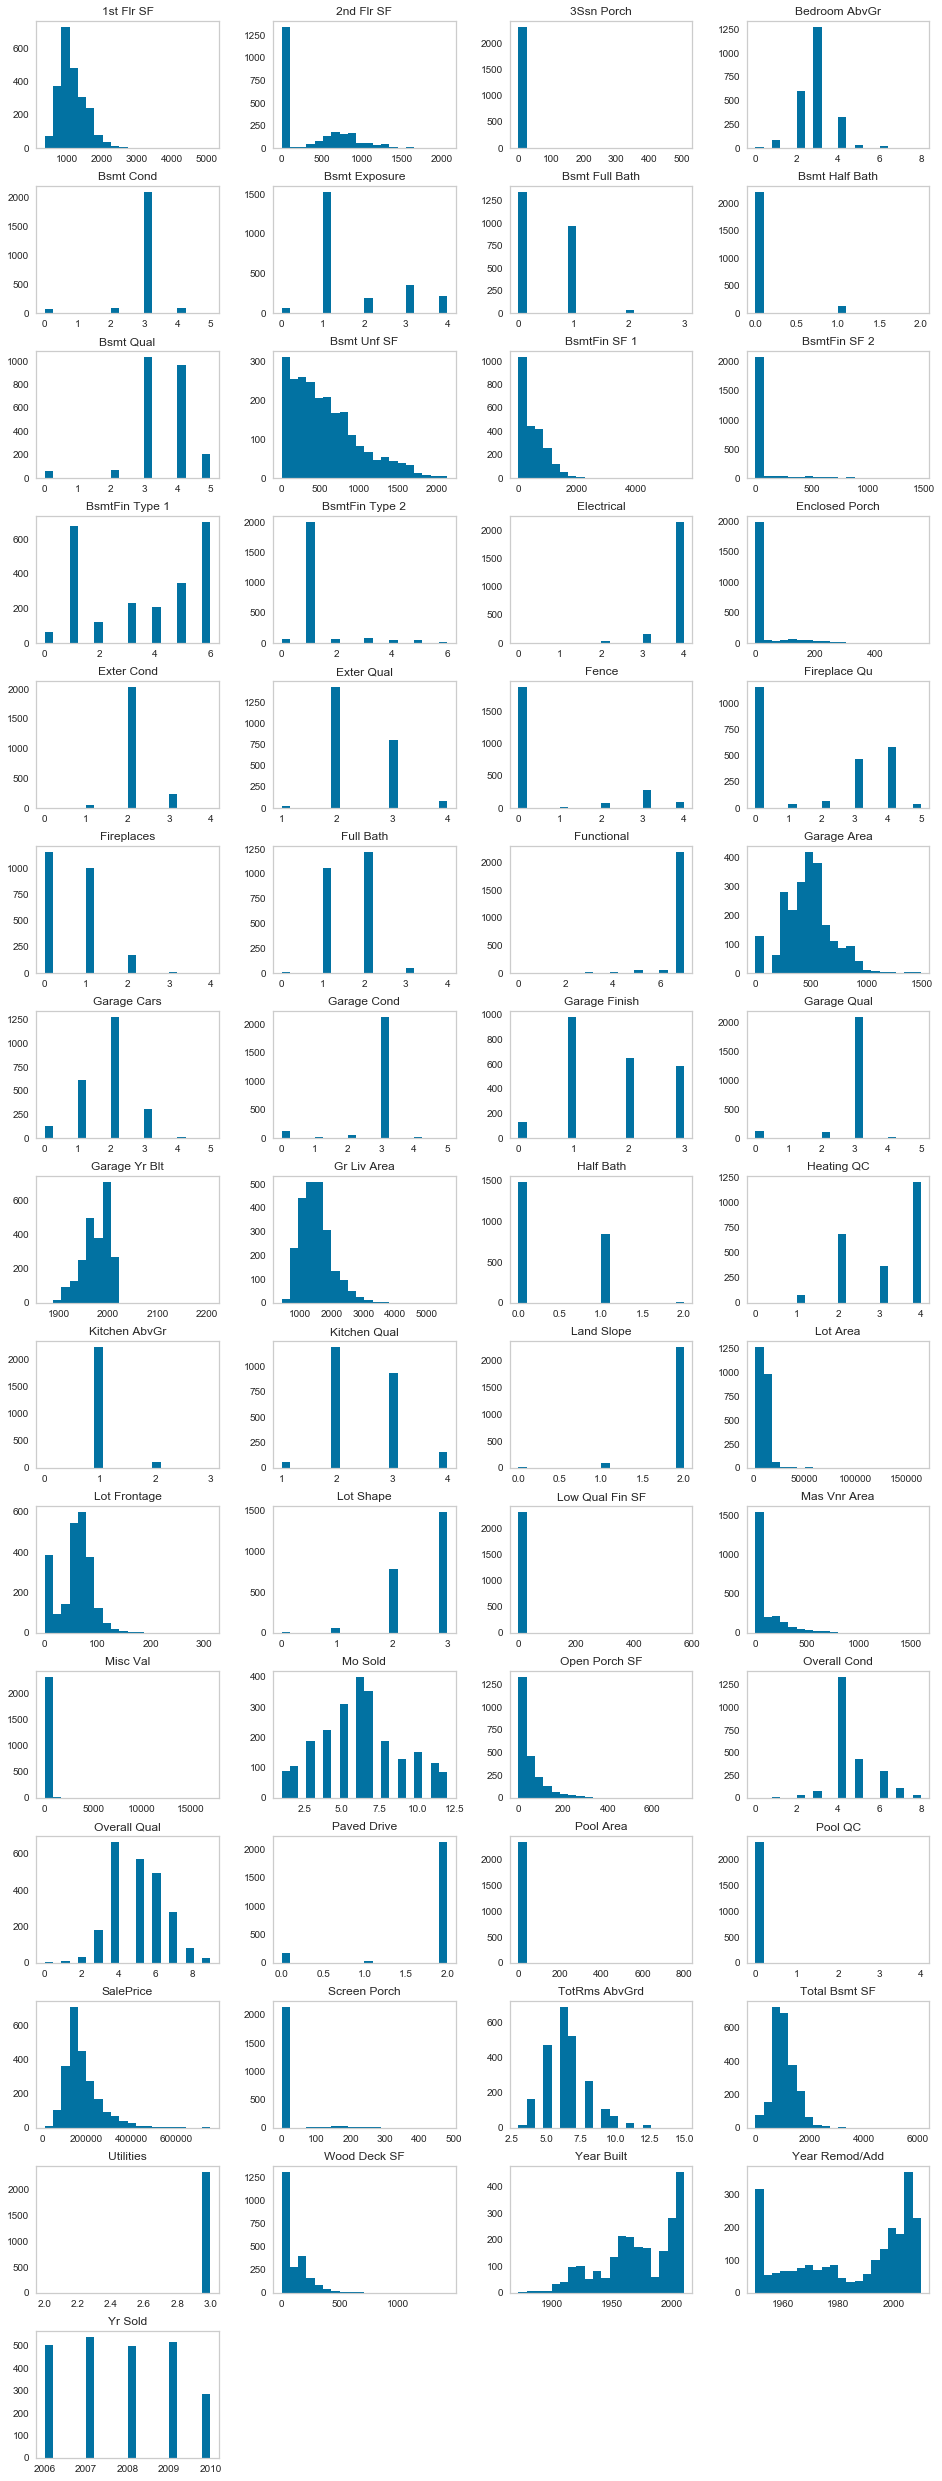

In [307]:
data.hist(figsize=(16,60), layout=(20,4), bins=20, grid=False);

In [308]:
data.loc[data["Garage Yr Blt"] > 2010, "Garage Yr Blt"] =  data.loc[data["Garage Yr Blt"] > 2010, "Year Built"]

## Plots of continuous variables vs target

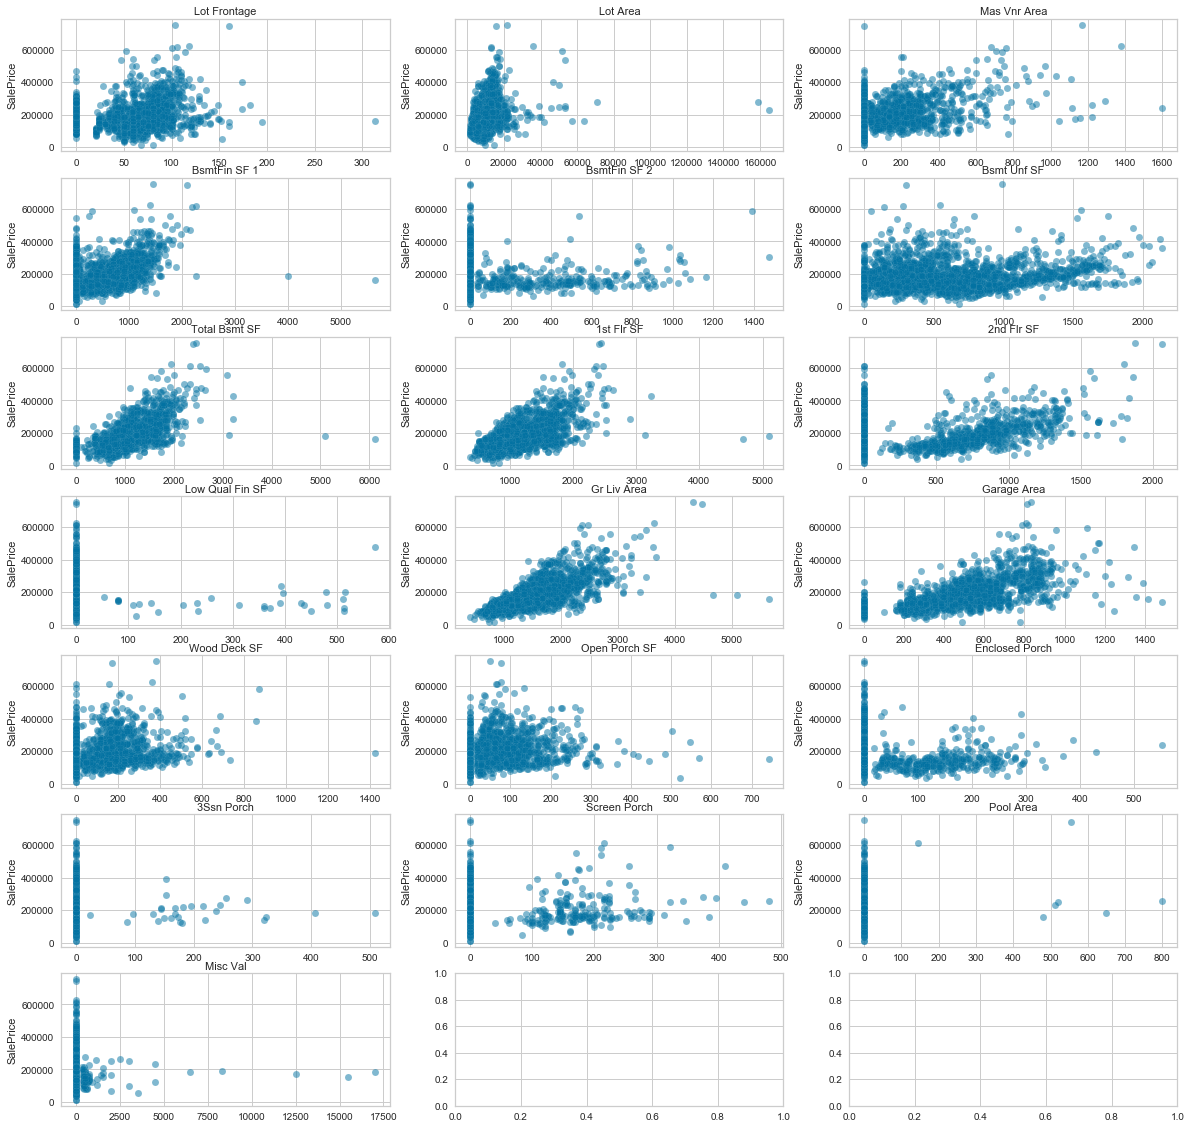

In [309]:
f, ax = plt.subplots(7, 3, figsize=(20,20))
to_plot = zip(flatten(ax), cont)
for ax, feature in to_plot:
    sns.scatterplot(data=data, y="SalePrice", x=feature, ax=ax, alpha=0.5, linewidth=0.1)
    ax.xaxis.set_label_position('top')

In [310]:
data = data[data["Gr Liv Area"] < 4000]
data = data[data["Lot Frontage"] < 200]
data = data[data["Lot Area"] < 40000]
data = data[data["BsmtFin SF 1"] < 3000]
data = data[data["Total Bsmt SF"] < 4000]
data = data[data["1st Flr SF"] < 4000]
data = data[data["Wood Deck SF"] < 1200]

## Plots of discrete and ordinal variables vs target

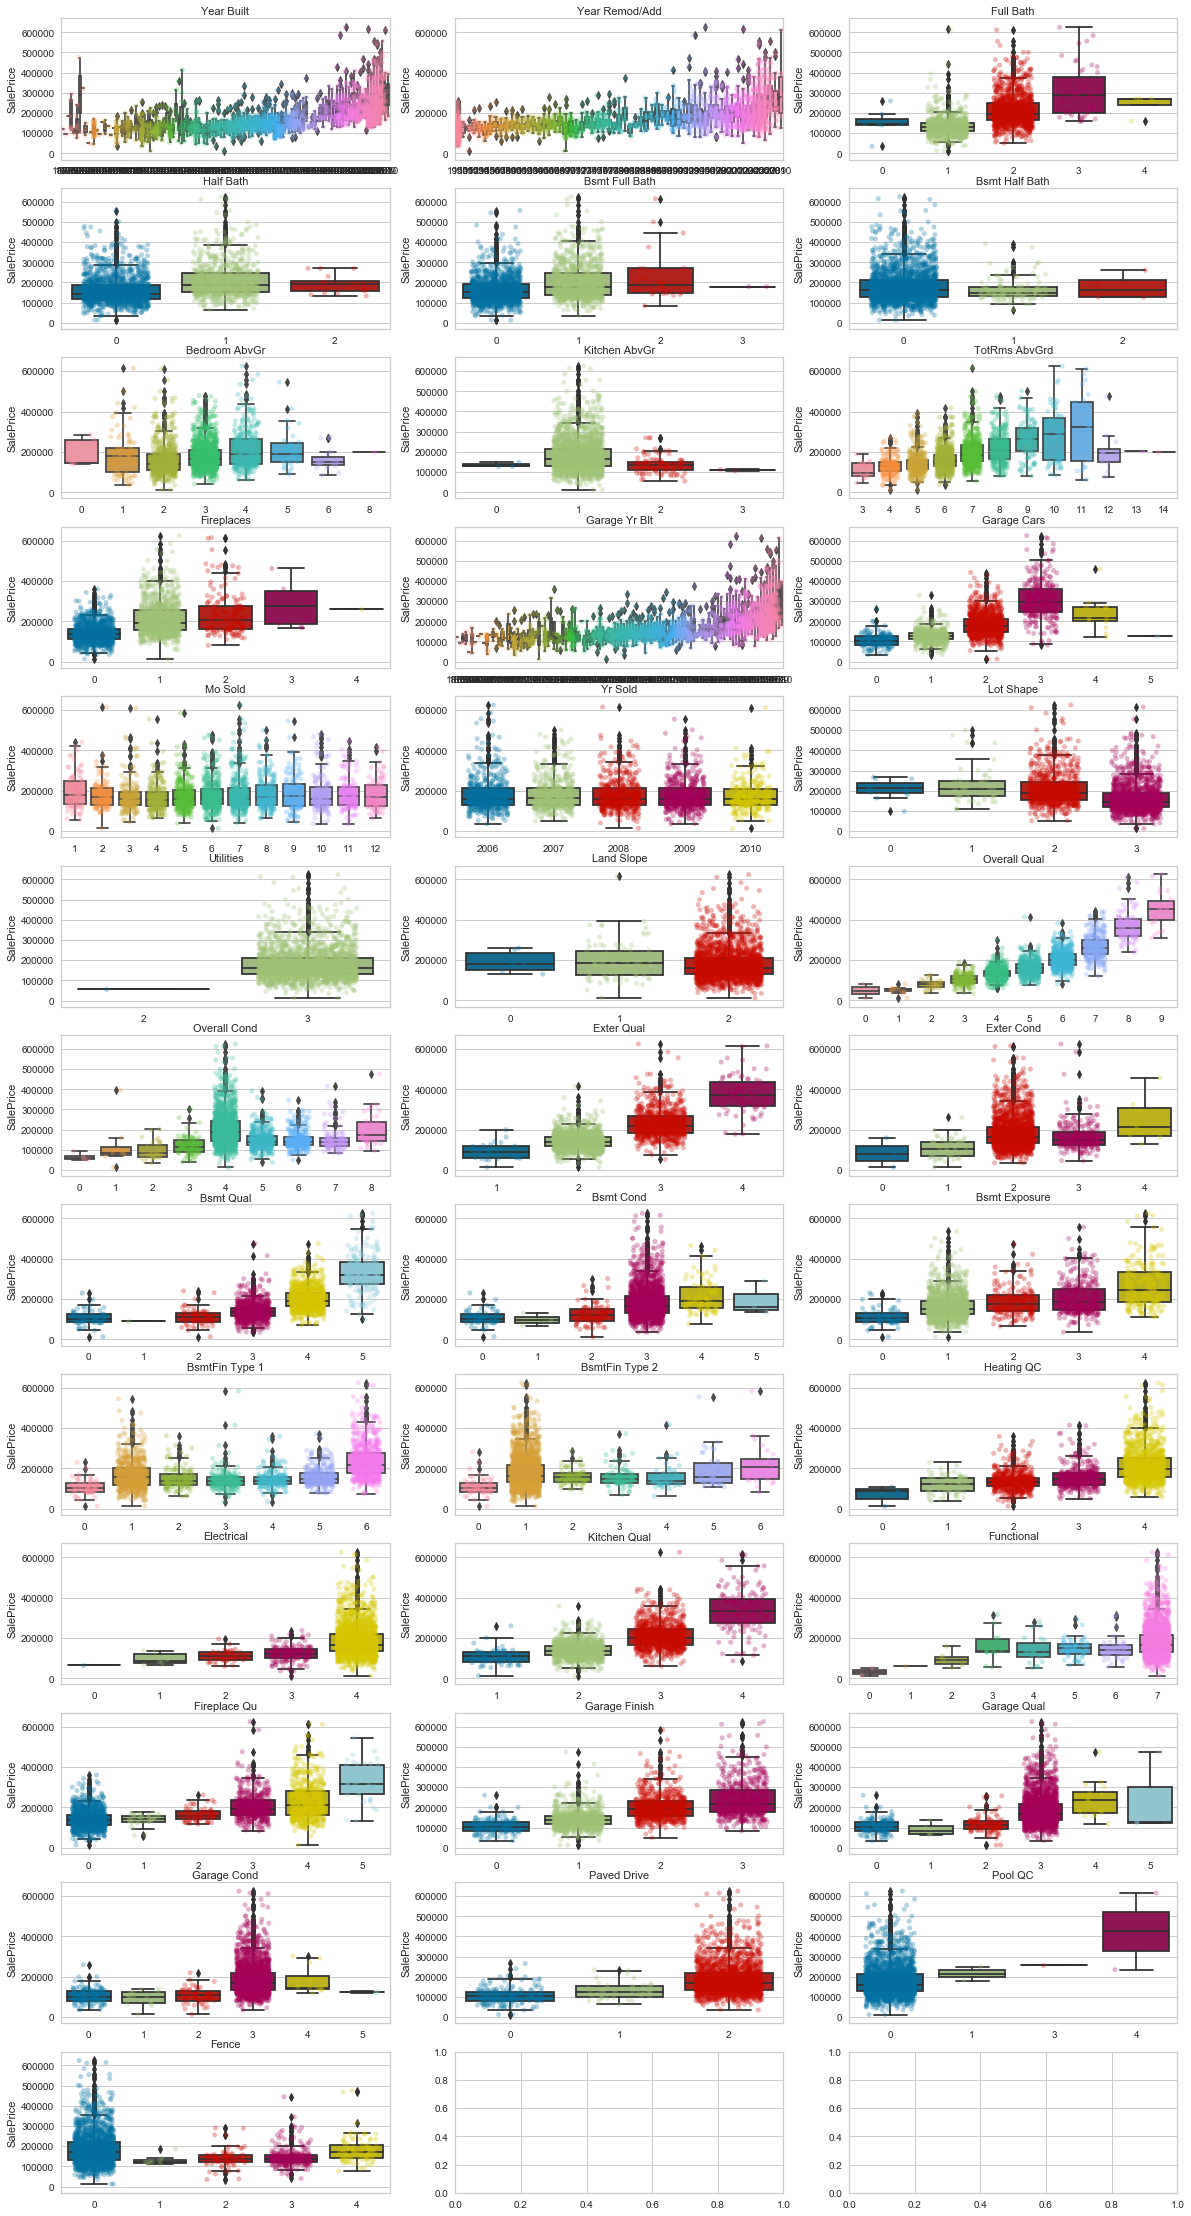

In [311]:
f, ax = plt.subplots(13, 3, figsize=(20,40))
to_plot = zip(flatten(ax), discrete+ordinal)
for ax, feature in to_plot:
    sns.boxplot(y="SalePrice", x=feature, data=data, ax=ax)
    sns.stripplot(y="SalePrice", x=feature, data=data, ax=ax, jitter=0.3, alpha=0.3)
    ax.xaxis.set_label_position('top')

In [312]:
data.loc[data["Full Bath"] == 0, "Full Bath"] = 1
data.loc[data["Full Bath"] == 4, "Full Bath"] = 3
data.loc[data["Half Bath"] == 2, "Half Bath"] = 1
data.loc[data["Bsmt Full Bath"].isin([2,3]), "Bsmt Full Bath"] = 1
data.loc[data["Bsmt Half Bath"] == 2, "Bsmt Half Bath"] = 1
data.loc[data["Bedroom AbvGr"].isin([5,6,7,8]), "Bedroom AbvGr"] = 4
data.loc[data["Bedroom AbvGr"].isin([0]), "Bedroom AbvGr"] = 1
data.loc[data["Kitchen AbvGr"].isin([0]), "Kitchen AbvGr"] = 1
data.loc[data["Kitchen AbvGr"].isin([3]), "Kitchen AbvGr"] = 2
data.loc[data["TotRms AbvGrd"].isin([12,13,14,15]), "TotRms AbvGrd"] = 11
data.loc[data["TotRms AbvGrd"].isin([3]), "TotRms AbvGrd"] = 4
data.loc[data["Fireplaces"].isin([3,4]), "Fireplaces"] = 2
data.loc[data["Garage Cars"].isin([4,5]), "Garage Cars"] = 3
data.loc[data["Lot Shape"].isin([0]), "Lot Shape"] = 1
data.loc[data["Land Slope"].isin([0]), "Land Slope"] = 1
data.loc[data["Garage Qual"].isin([4,5]), "Garage Qual"] = 3
data.loc[data["Garage Cond"].isin([4,5]), "Garage Cond"] = 3

## Plots of nominal variables vs target

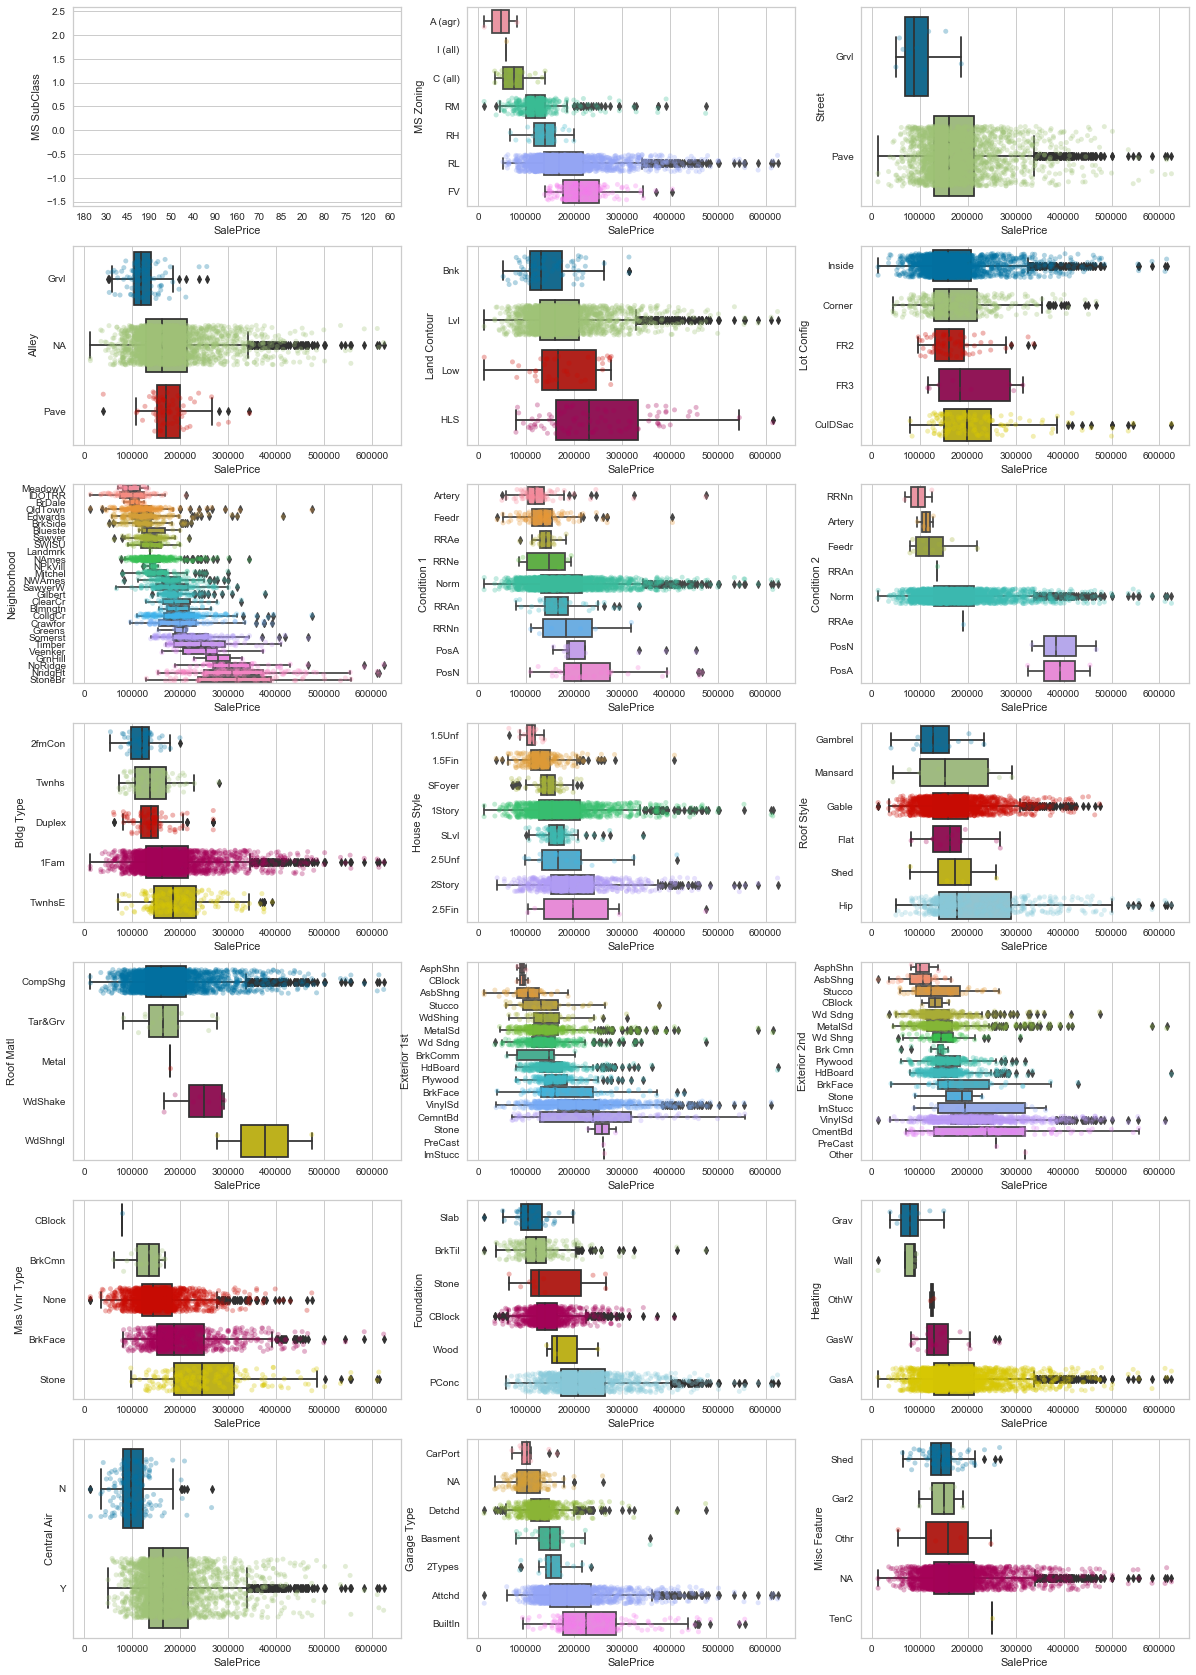

In [313]:
f, ax = plt.subplots(7, 3, figsize=(20,30))
to_plot = zip(flatten(ax), nominal)
for ax, feature in to_plot:
    order = data.groupby(feature)["SalePrice"].median().sort_values().index
    sns.boxplot(x="SalePrice", y=feature, data=data, order=order, ax=ax)
    sns.stripplot(x="SalePrice", y=feature, data=data, order=order, ax=ax, jitter=0.3, alpha=0.3)

## Plot of Neighborhood vs target

Because it was too cramped in the previous plot and seems relevant.

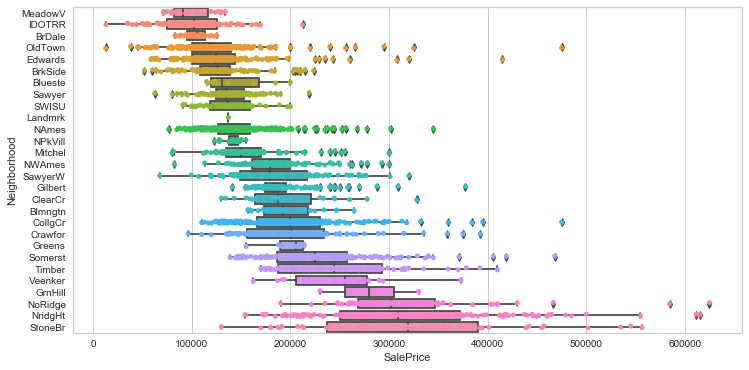

In [314]:
plt.figure(figsize=(12,6))
neighborhoods = data.groupby("Neighborhood")["SalePrice"].median()
neighborhoods = neighborhoods.sort_values()
sns.boxplot(x="SalePrice", y="Neighborhood", data=data, order=neighborhoods.index)
sns.stripplot(x="SalePrice", y="Neighborhood", data=data, order=neighborhoods.index);

## Correlation Matrix

In [315]:
corr_matrix = data.corr()

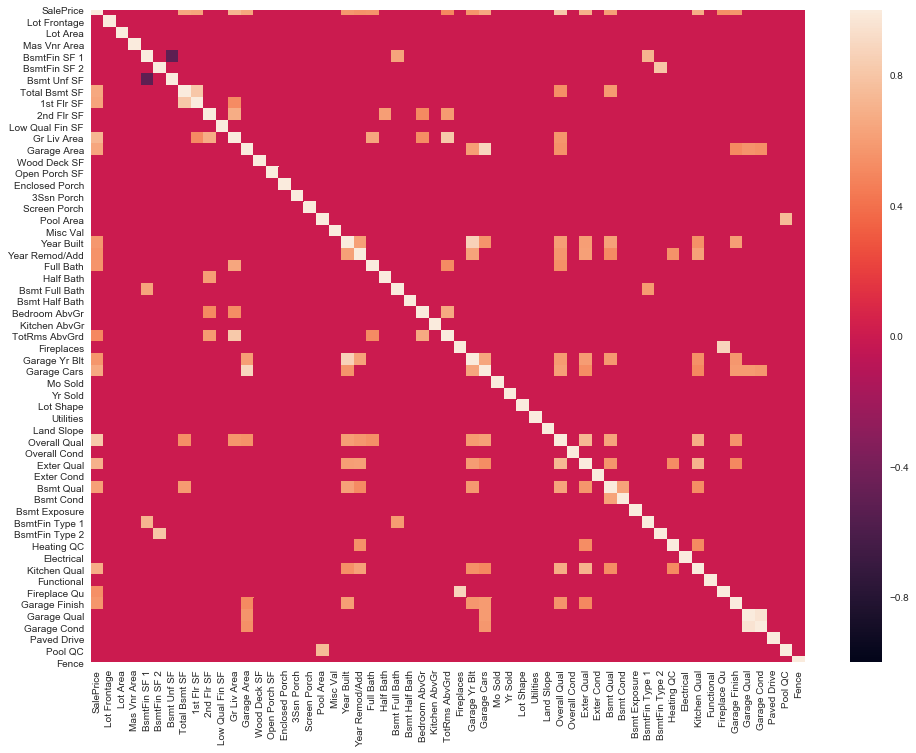

In [316]:
f = plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix[corr_matrix.abs() > 0.5].fillna(0), vmin=-1, vmax=1);

In [317]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype("bool"))
corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
corr_features

['Garage Cond']

In [318]:
discarded_features = ["Pool Area", "Pool QC", "Low Qual Fin SF", "3Ssn Porch", "Misc Val", "Utilities"]
data = data.drop(columns=discarded_features)
target, cont, discrete, ordinal, nominal = get_features(data)

In [362]:
train = data.copy()
train_du = pd.get_dummies(data, columns=data.select_dtypes(include="object").columns, drop_first=False)
train_df = pd.get_dummies(data, columns=data.select_dtypes(include="object").columns, drop_first=True)

# Modelling

In [397]:
X, y = prepare_data_for_model(train_du)

In [400]:
X_train, X_val, y_train, y_val = prepare_data_for_model(train_du, val_size=0.2)

### Ridge Regression

In [443]:
steps = [
    ('scale', StandardScaler()), 
    ('feature_selection', RFECV(Ridge(), min_features_to_select=10, cv=5, scoring="neg_mean_absolute_error")),
    ('ridge_regression', RidgeCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100)))
]
model_ridge = Pipeline(steps)

In [444]:
score_model(model_ridge, X, y, metrics)

R2: 0.91130836123234
MAE: -15938.827672127081
RMSE: -22848.94125611883


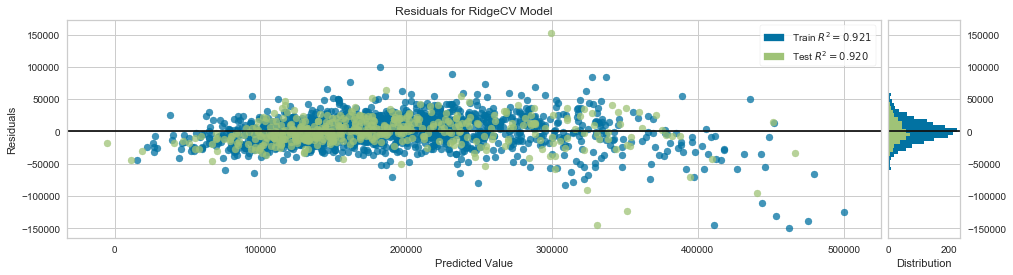

In [436]:
visualizer = ResidualsPlot(model_ridge)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

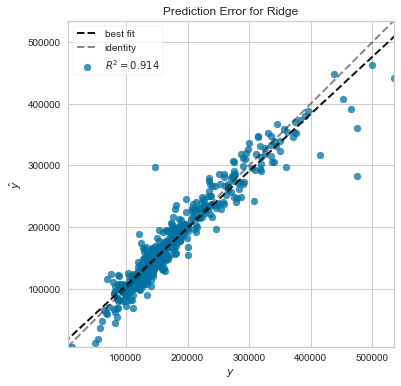

In [426]:
plt.figure(figsize=(6,6))
visualizer = PredictionError(model_ridge)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

In [392]:
X_train.columns[model_ridge["feature_selection"].support_]

Index(['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area',
       ...
       'Sale Type_CWD', 'Sale Type_Con', 'Sale Type_ConLD', 'Sale Type_New',
       'Sale Type_Oth', 'Sale Condition_AdjLand', 'Sale Condition_Alloca',
       'Sale Condition_Family', 'Sale Condition_Normal',
       'Sale Condition_Partial'],
      dtype='object', length=155)

### Lasso

In [445]:
steps = [
    ('scale', RobustScaler()), 
    ('lasso', LassoCV(max_iter=10000, alphas=(0.001, 0.01, 0.1, 1, 10, 100)))
]
model_lasso = Pipeline(steps)

In [446]:
score_model(model_lasso, X, y, metrics)

R2: 0.9152334735889301
MAE: -15834.558511604355
RMSE: -22387.098992712923


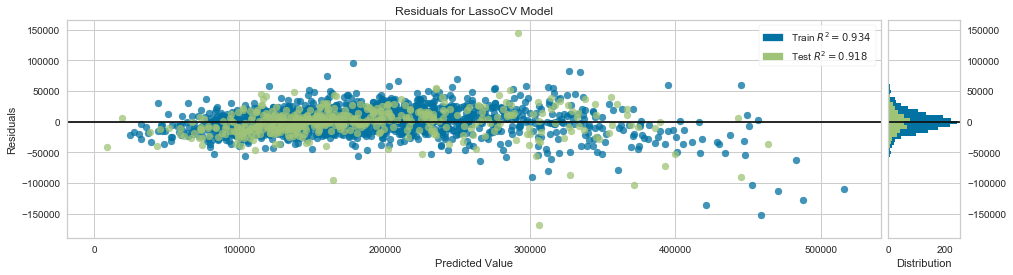

In [447]:
visualizer = ResidualsPlot(model_lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

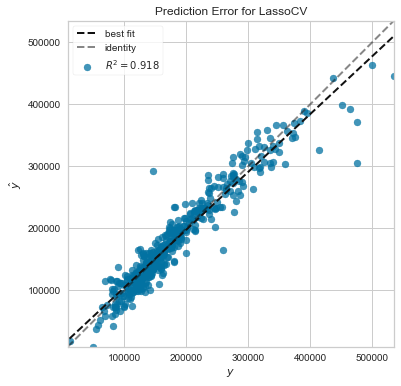

In [448]:
plt.figure(figsize=(6,6))
visualizer = PredictionError(model_lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

# Decision Tree

In [405]:
X, y = prepare_data_for_model(train_du)

In [406]:
model_tree = DecisionTreeRegressor()
score_model(model_tree, X, y, metrics)

R2: 0.8137281844388939
MAE: -22443.03242563268
RMSE: -32931.401291914095


In [407]:
model_tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [408]:
important_features_idx = np.flip(np.argsort(model_tree.feature_importances_))
important_features_names = X.columns[important_features_idx]
importances = model_tree.feature_importances_[important_features_idx]
feature_scores = list(zip(important_features_names, importances))

[(name, score) for name, score in feature_scores if score >= 0.01]

[('Overall Qual', 0.6866028438031343),
 ('Gr Liv Area', 0.10045635740199158),
 ('Garage Cars', 0.03560283744244729),
 ('Total Bsmt SF', 0.02547735769194952),
 ('1st Flr SF', 0.022113732469183994),
 ('BsmtFin SF 1', 0.015320008803633118),
 ('Lot Area', 0.011407874999575367)]

In [ ]:
select_features = SelectFromModel(model_tree, threshold=0.01, prefit=True)
X_tree = select_features.transform(X)

In [ ]:
score_model(model_tree, X_tree, y, metrics)

# Random Forest

In [458]:
X, y = prepare_data_for_model(train_du)

In [459]:
model_forest = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
score_model(model_forest, X, y, metrics)

R2: 0.9101339915729512
MAE: -14945.233543385373
RMSE: -23005.149742512873


In [46]:
model_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
important_features_idx = np.flip(np.argsort(model_forest.feature_importances_))
important_features_names = X.columns[important_features_idx]
importances = model_forest.feature_importances_[important_features_idx]
feature_scores = list(zip(important_features_names, importances))

[(name, score) for name, score in feature_scores if score >= 0.01]

[('Overall Qual', 0.6535005756877363),
 ('Gr Liv Area', 0.10203796458083084),
 ('Total Bsmt SF', 0.028510827182919595),
 ('1st Flr SF', 0.02560235846942288),
 ('2nd Flr SF', 0.022297013718537647),
 ('BsmtFin SF 1', 0.019864317834934305),
 ('Lot Area', 0.015372556513442059),
 ('Garage Cars', 0.014586383659542783),
 ('Garage Area', 0.013022775980788224),
 ('Year Built', 0.012184532149721958)]

In [48]:
select_features = SelectFromModel(model_forest, threshold=0.01, prefit=True)
X_forest = select_features.transform(X)

In [49]:
score_model(model_forest, X_forest, y, metrics)

R2: 0.8914238033399166
MAE: -16745.716028298062
RMSE: -25930.044970258616
